# week4 授業課題 信用情報の学習
# 【問題1】コンペティション内容の確認
* 顧客の返済能力の予測
* 予測するのは，お金を貸した顧客がちゃんと返すか，返さないのか
* 返す顧客の方が圧倒的に多い夫君項データなので，評価はAUCで行う．

# ベースラインモデルの作成
まずは単純な方法による ベースラインモデル　を作成します。精度の基準となるモデルです。                 
精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。                     
# 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。                          
検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。
# 【問題3】テストデータに対する推定  
テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。                     
正しく提出が行えていれば、精度は低くても構いません。

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [4]:
#データを用意
train_data = pd.read_csv('C:/Users/miyas/kaggle/application_train.csv')
test_data = pd.read_csv('C:/Users/miyas/kaggle/application_test.csv')

In [6]:
# 欠損値の確認
print('train欠損値：\n',train_data.isnull().sum())
print('test欠損値：\n',test_data.isnull().sum())

train欠損値：
 SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64
test欠損値：
 SK_ID_CURR                       0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY     6049
AMT_REQ_CREDIT_BUREAU_WEEK    6049
AMT_REQ_CREDIT_BUREAU_MON     6049
AMT_REQ_CREDIT_BUREAU_QRT     6049
AMT_REQ_CREDIT_BUREAU_YEAR    6049
Length: 121, dtype: int64


In [13]:
# データを特徴用と目的変数に分ける
X = train_data.drop('TARGET',axis=1)
y = train_data.TARGET

#trainデータとtestデータの前処理を同じにするため，一度データを結合する
X['train_test'] = 0
test_data['train_test'] = 1
A = pd.concat([X,test_data])
A = pd.DataFrame(A)
A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 122 entries, SK_ID_CURR to train_test
dtypes: float64(65), int64(41), object(16)
memory usage: 334.3+ MB


In [14]:
#今回は時間の関係上，欠損値のある特徴量は削除する
A2 = A.dropna(axis=1,how='any')
A3 = A2.dropna(how='any')
X = A3[A3['train_test'] == 0]
test = A3[A3['train_test'] == 1]
X = X.drop('train_test',axis=1)
test = test.drop('train_test',axis=1)

In [15]:
#shapeを確認する
print('X:',X.shape)
print('test:',test.shape)

X: (307511, 54)
test: (48744, 54)


In [16]:
#object型の変数の数を数える
X.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

In [17]:
from sklearn.preprocessing import LabelEncoder
#ラベルエンコーダーをインスタンス化
le = LabelEncoder()
le_count = 0

# object型の変数でユニーク値が２以下のものはラベルエンコーダーする
for col in X:
    if X[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(X[col].unique())) <= 2:
            le.fit(X[col])
            # トレーニングデータとテストデータの両方を変換する
            X[col] = le.transform(X[col])
            test[col] = le.transform(test[col])
            
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


print('Training Features shape: ', X.shape)
print('Testing Features shape: ', test.shape)

3 columns were label encoded.
Training Features shape:  (307511, 54)
Testing Features shape:  (48744, 54)


In [18]:
# ユニーク値が３以上のものはone-hot encoding
X = pd.get_dummies(X)
test = pd.get_dummies(test)

print('Training Features shape: ', X.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 140)
Testing Features shape:  (48744, 137)


In [19]:
# トレーニングデータとテストデータを調整し、両方のデータフレームに列のみを保持する
X, test = X.align(test, join = 'inner', axis = 1)

print('Training Features shape: ', X.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 137)
Testing Features shape:  (48744, 137)


In [20]:
X.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

In [21]:
#ロジスティック回帰モデル
from sklearn.linear_model import LogisticRegression
#訓練データとテストデータに分ける
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# インスタンス化
lr = LogisticRegression()
# 学習
lr.fit(X_train,y_train)

# 推定
y_pred = lr.predict(X_test)

C:\Users\miyas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
#評価
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('accuracy_score:',accuracy_score(y_test,y_pred))
print('precision_score:',precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score:',recall_score(y_true=y_test, y_pred=y_pred))
print('F値:',f1_score(y_true=y_test, y_pred=y_pred))

accuracy_score: 0.9204370542198712
precision_score: 0.0
recall_score: 0.0
F値: 0.0


In [25]:
#推定値の中身
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

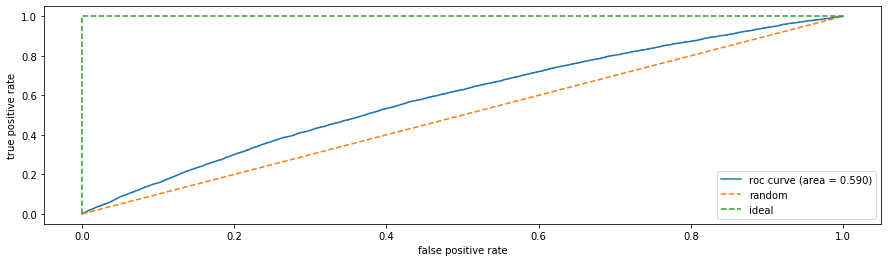

In [26]:
# AUCとROCを求める
from sklearn.metrics import roc_curve, auc

# テストデータが「１」に属する確率
Y_score = lr.predict_proba(X_test)[:, 1]
# ROCを求める
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)

#グラフサイズ
plt.figure(figsize=(15,4))

# ROC曲線を描く（X軸がFPR、Y軸がTPR　※auc(fpr, tpr)でauc値を求めている
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
#あてずっぽうの線
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
#AUCが１の場合の線
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')

# 凡例
plt.legend()
# 軸の名前
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [28]:
print('AUCロジスティック',auc(fpr, tpr))

AUCロジスティック 0.5897319207848634


# 4.特徴量エンジニアリング
ベースラインモデルを元に、入力する特徴量に様々な工夫を行い精度を向上させていきます。                  
# 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。                        
* どの特徴量を使うか
* どう前処理をするか
何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。            
精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

## 試したこと
* ユニーク値が２以下の変数はラベルエンコーダーで０，１の値にし，ユニーク値がそれ以上のものはOneHotEncodingした．                 
理由：ユニーク値が多いものをラベルエンコーダーしてしまうと数字の大小に意味を持ってしまうから
* データの標準化

In [29]:
# 標準化
from sklearn.preprocessing import StandardScaler

# 標準化処理
sc = StandardScaler()
# 訓練データの平均と標準偏差を計算
sc.fit(X_train)     ### Point!!! 訓練データの平均と標準偏差を使って標準化すること ###
X_train_std = sc.transform(X_train) #訓練でデータの説明変数を上で求めた平均と標準偏差を使って標準化している
X_test_std = sc.transform(X_test)   #テストデータの説明変数を標準化

In [30]:
# 学習
lr.fit(X_train_std,y_train)

# 推定
y_pred = lr.predict(X_test_std)

C:\Users\miyas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
print('accuracy_score:',accuracy_score(y_test,y_pred))
print('precision_score:',precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score:',recall_score(y_true=y_test, y_pred=y_pred))
print('F値:',f1_score(y_true=y_test, y_pred=y_pred))

accuracy_score: 0.9204370542198712
precision_score: 0.0
recall_score: 0.0
F値: 0.0


C:\Users\miyas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\miyas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


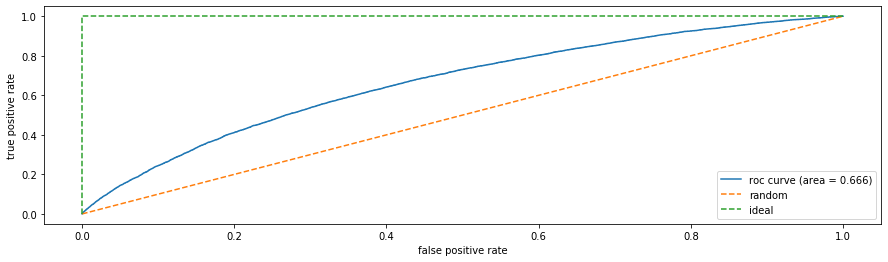

In [32]:
# テストデータが「１」に属する確率
Y_score = lr.predict_proba(X_test_std)[:, 1]
# ROCを求める
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)

#グラフサイズ
plt.figure(figsize=(15,4))

# ROC曲線を描く（X軸がFPR、Y軸がTPR　※auc(fpr, tpr)でauc値を求めている
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
#あてずっぽうの線
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
#AUCが１の場合の線
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')

# 凡例
plt.legend()
# 軸の名前
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [33]:
print(auc(fpr, tpr))

0.6656498057114237


## モデルを決定木にしてみる

In [34]:
from sklearn.tree import DecisionTreeClassifier

# 決定木クラスの初期化
dc = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=0)
# 学習
dc.fit(X_train_std,y_train)

# 推定
y_pred = dc.predict(X_test_std)

In [35]:
print('accuracy_score:',accuracy_score(y_test,y_pred))
print('precision_score:',precision_score(y_true=y_test, y_pred=y_pred))
print('recall_score:',recall_score(y_true=y_test, y_pred=y_pred))
print('F値:',f1_score(y_true=y_test, y_pred=y_pred))

accuracy_score: 0.9204370542198712
precision_score: 0.0
recall_score: 0.0
F値: 0.0


C:\Users\miyas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\miyas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


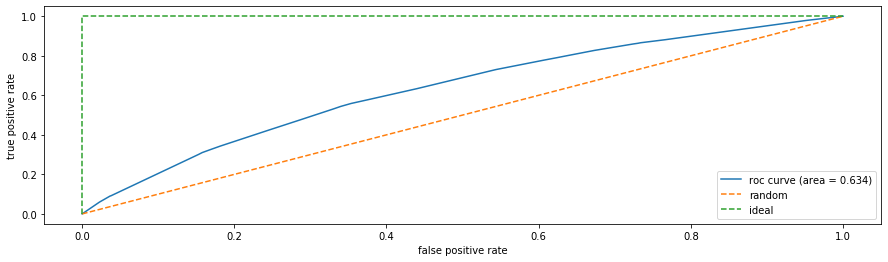

In [36]:
# テストデータが「１」に属する確率
Y_score = dc.predict_proba(X_test_std)[:, 1]
# ROCを求める
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)

#グラフサイズ
plt.figure(figsize=(15,4))

# ROC曲線を描く（X軸がFPR、Y軸がTPR　※auc(fpr, tpr)でauc値を求めている
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
#あてずっぽうの線
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
#AUCが１の場合の線
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')

# 凡例
plt.legend()
# 軸の名前
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [37]:
print('決定木：',auc(fpr, tpr))

決定木： 0.6343865140938557


欠損値のパターンを見る（ランダムなら無視するとか）

メモ               
* 1.連続値かカテゴリか                            　　　　　　　　　　
* 　→カテゴリはエンコーディング                                   　　　　　　　　　　　　
* 　→連続値は離散化する　ex)ビン分割する→新しい特徴量                            　　　　　　　　　　　　　　　　
* ２．ほかの特徴量との相関&ターゲットとの相関→重要度                         　　
* ３．正規分布かどうか→ロジスティックは正規分布
* 　→正規分布じゃなければ対数変換
* ４．標準化と正規化
* 　標準化＝平均０分散１
* 　正規化＝０～１などの範囲に収める